In [1]:
import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
import cartopy.crs as ccrs


import torch
from torch.utils.data import Dataset
import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache
from torch.utils.data import Dataset, DataLoader


import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

from denoising_diffusion_pytorch.attend import Attend

from denoising_diffusion_pytorch.version import __version__
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

In [2]:
file_do = '/glade/derecho/scratch/wchapman/Gen_CESM/samples_yield_advantages_month12_001.nc'
mo_lens = 12

## Show regression maps

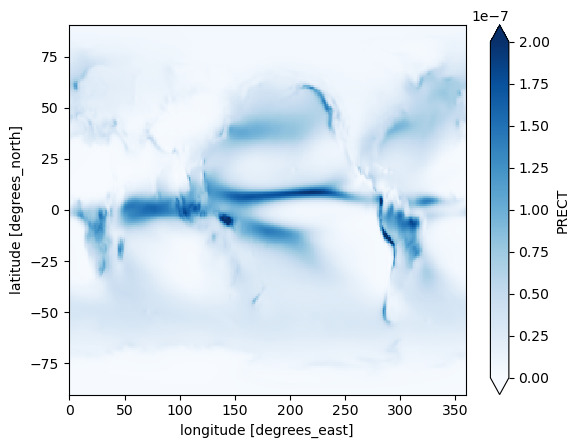

In [3]:
DS = xr.open_dataset(file_do)
DS['PRECT'].mean('samples').plot(cmap='Blues',vmin=0,vmax=2e-7)
plt.show()

In [4]:
DS = xr.open_dataset(file_do)

def compute_regression_slopes(DS, region_lat=(-5, 5), region_lon=(190, 240)):
    """
    Compute the regression slopes of each variable (PS, PRECT, TREFHT) with respect to the mean of TREFHT
    over a specified region.

    Parameters:
    DS (xarray.Dataset): The dataset containing the variables.
    region_lat (tuple): Latitude bounds for selecting the region (default: (-5, 5)).
    region_lon (tuple): Longitude bounds for selecting the region (default: (190, 240)).

    Returns:
    dict: A dictionary containing the slope datasets for each variable (PS, PRECT, TREFHT).
    """
    
    # Step 1: Select the mean of TREFHT over the specified region
    trefht_mean = DS['TREFHT'].sel(lat=slice(*region_lat), lon=slice(*region_lon)).mean(dim=['lat', 'lon'])
    
    # Step 2: Demean the independent variable (TREFHT)
    trefht_mean_demeaned = trefht_mean - trefht_mean.mean(dim='samples')
    
    # Step 3: Loop over each variable and compute the slope at each (lat, lon) point
    regression_slopes = {}
    for var_name in ['PS', 'PRECT', 'TREFHT']:
        # Demean the dependent variable at each (lat, lon) point
        y = DS[var_name]
        y_demeaned = y - y.mean(dim='samples')
        
        # Compute the slope (cov(y, x) / var(x)) at each (lat, lon) point
        slope = (y_demeaned * trefht_mean_demeaned).mean(dim='samples') / (trefht_mean_demeaned ** 2).mean(dim='samples')
        
        # Store the slope result for this variable
        regression_slopes[var_name] = slope
    
    return regression_slopes

# Example usage:
# Assuming DS is already loaded with the required variables
# DS = xr.open_dataset('path_to_file.nc')

In [5]:
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors

# # Assuming your dataset is already loaded and slope_PS and slope_TREFHT are calculated
# # Replace with the correct path to your dataset
# DS = xr.open_dataset(file_do)

# # Extracting the slope_PS and slope_TREFHT (for demonstration purpose assuming it's calculated)
# # slope_PS = DS['PS']  # Adjust based on how the slope was computed
# # slope_TREFHT = DS['TREFHT']  # Adjust based on how the slope was computed

# # Define discrete color levels
# levels = list(np.arange(-1.3,1.4,.1))
# levels
# cmap = plt.get_cmap('RdBu_r')
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# # Color-filled plot for TREFHT with discrete levels
# prect_plot = slope_TREFHT.plot(
#     ax=ax, 
#     transform=ccrs.PlateCarree(), 
#     cmap=cmap, 
#     norm=norm, 
#     add_colorbar=True, 
#     cbar_kwargs={'boundaries': levels, 'ticks': levels}
# )
# plt.title('Global Plot: TREFHT (color) and PS (contours)')

# # Adding contour lines for PS
# contour = ax.contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
# ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# # Adding coastlines and formatting
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_xticks([120, 150, 180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120], crs=ccrs.PlateCarree())
# ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# plt.tight_layout()
# plt.show()


In [6]:
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors
# import numpy as np

# # Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# # Replace with the correct path to your dataset
# DS = xr.open_dataset(file_do)

# # Define discrete color levels
# levels = list(np.arange(-.7, .75, .05) * 1e-8)
# cmap = plt.get_cmap('RdBu_r')
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# # Define fewer ticks for the colorbar
# fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# # Set extent to zoom in on a particular region
# ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# # Color-filled plot for TREFHT with discrete levels
# prect_plot = slope_PRECT.plot(
#     ax=ax, 
#     transform=ccrs.PlateCarree(), 
#     cmap=cmap, 
#     norm=norm, 
#     add_colorbar=True, 
#     cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
# )
# plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# # Adding contour lines for PS
# contour = ax.contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
# ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# # Adding coastlines and formatting
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
# ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# plt.tight_layout()
# plt.show()


## Grab the LENS

In [7]:

def concat_files_by_month(month_get, file_pattern):
    """
    Concatenate datasets along a 'samples' dimension, selecting data from a specific month.

    Parameters:
    month_get (int): The month to filter by (e.g., 2 for February).
    file_pattern (str): The glob pattern for the input NetCDF files.

    Returns:
    xarray.Dataset: Concatenated dataset along the 'samples' dimension.
    """
    # Step 1: Get the list of files
    FNS = sorted(glob.glob(file_pattern))

    # Step 2: Create an empty list to hold the filtered datasets
    datasets = []

    # Track the running count of samples
    sample_counter = 0

    # Step 3: Loop over each file and load the dataset, selecting only data for the given month
    for fps in FNS:
        # Open the dataset
        # print(fps)
        DS = xr.open_dataset(fps)

        # Select only data from the specified month
        mo_g = month_get+1

        if mo_g == 13:
            mo_g = 1
        
        DS_feb = DS.sel(time=DS['time.month'] == mo_g)

        # Determine the number of time steps in the current dataset
        n_samples = DS_feb.sizes['time']

        # Replace the 'time' dimension with 'samples' and increment the sample index
        DS_feb = DS_feb.rename({'time': 'samples'})  # Rename 'time' to 'samples'

        # Assign a new 'samples' coordinate, starting from the running sample counter
        DS_feb = DS_feb.assign_coords(samples=(sample_counter + np.arange(n_samples)))

        # Update the sample counter for the next dataset
        sample_counter += n_samples

        # Append the modified dataset to the list
        datasets.append(DS_feb)

    # Step 4: Concatenate along the new "samples" dimension
    DS_concat = xr.concat(datasets, dim='samples')

    return DS_concat

# Example usage:
# Specify the month you want to extract (e.g., 2 for February)
month_get = mo_lens
file_pattern = '/glade/derecho/scratch/wchapman/CESM_LE2_vars_with_climo/*.nc'

# Call the function to concatenate datasets
DS_lens = concat_files_by_month(month_get, file_pattern)

# Optionally, save the concatenated dataset to a new NetCDF file
# DS_concat.to_netcdf('/path/to/save/concatenated_feb_samples.nc')

# Print the concatenated dataset for confirmation
print(DS_lens)


<xarray.Dataset> Size: 1GB
Dimensions:   (samples: 1650, lat: 192, lon: 288)
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * samples   (samples) int64 13kB 0 1 2 3 4 5 ... 1644 1645 1646 1647 1648 1649
Data variables:
    PS        (samples, lat, lon) float32 365MB 6.873e+04 ... 1.006e+05
    PRECT     (samples, lat, lon) float32 365MB 2.068e-09 2.068e-09 ... 4.78e-09
    TREFHT    (samples, lat, lon) float32 365MB 245.5 245.5 ... 253.7 253.7
    CLIM_T2M  (samples, lat, lon) float32 365MB 245.3 245.3 ... 245.4 245.4
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1001-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

In [8]:
slopes_lens = compute_regression_slopes(DS_lens.sel(samples=slice(0,1000)))
# You can access the slope maps for each variable, for example:
slope_PS_lens = slopes_lens['PS']
slope_PRECT_lens = slopes_lens['PRECT']
slope_TREFHT_lens = slopes_lens['TREFHT']

# Call the function to compute slopes
slopes = compute_regression_slopes(DS.sel(samples=slice(0,1000)))
# You can access the slope maps for each variable, for example:
slope_PS = slopes['PS']
slope_PRECT = slopes['PRECT']
slope_TREFHT = slopes['TREFHT']


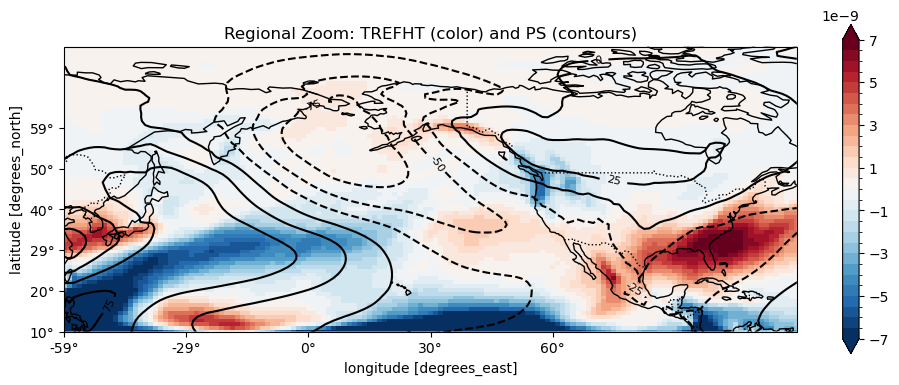

In [9]:

# Assuming your dataset is already loaded and slope_PS and slope_PRECT are calculated
# Replace with the correct path to your dataset
# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent to zoom in on a particular region
ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]

# Color-filled plot for TREFHT with discrete levels
prect_plot = slope_PRECT_lens.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmap, 
    norm=norm, 
    add_colorbar=True, 
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
)
plt.title('Regional Zoom: TREFHT (color) and PS (contours)')

# Adding contour lines for PS
contour = ax.contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=10, colors='black', transform=ccrs.PlateCarree())
ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Adding coastlines and formatting
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


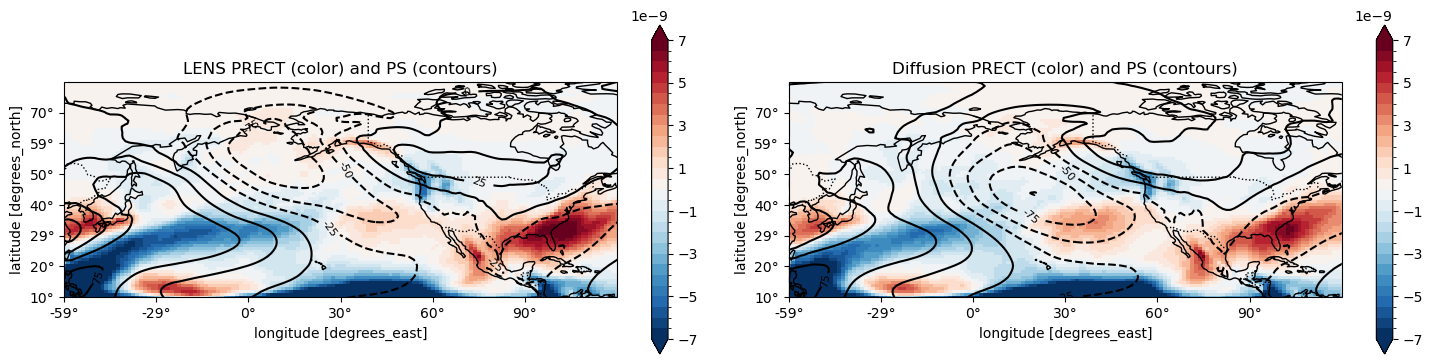

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# Assuming slope_PS_lens, slope_PS, slope_PRECT_lens, slope_PRECT are calculated

# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]

# Plotting with two panels
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for zoomed region
extent = [120, 300, 10, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=True,
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}
)
axs[0].set_title('LENS PRECT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=10, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks([120, 150, 180, 210, 240, 270], crs=ccrs.PlateCarree())
axs[0].set_yticks([10, 20, 30, 40, 50, 60, 70], crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=True,
    cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}
)
axs[1].set_title('Diffusion PRECT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=10, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks([120, 150, 180, 210, 240, 270], crs=ccrs.PlateCarree())
axs[1].set_yticks([10, 20, 30, 40, 50, 60, 70], crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

plt.tight_layout()
plt.show()


/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/108193656.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


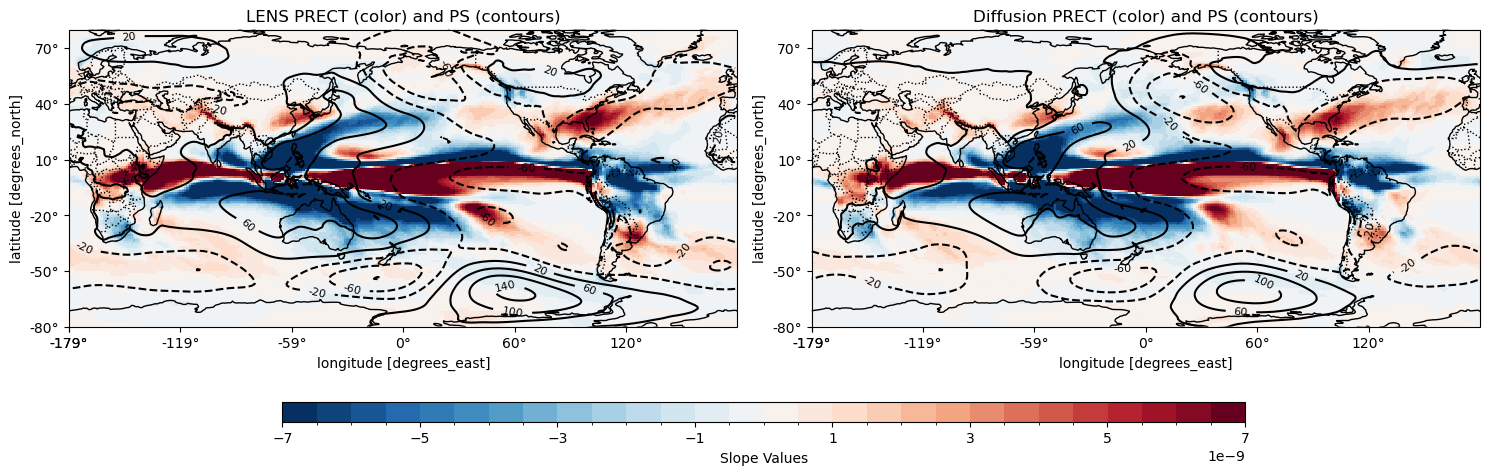

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# Assuming slope_PS_lens, slope_PS, slope_PRECT_lens, slope_PRECT are calculated

# Define discrete color levels
levels = list(np.arange(-.7, .75, .05) * 1e-8)
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]

# Standardized contour levels for both PS datasets
contour_levels = np.linspace(-300, 300, 16)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for both panels (same zoomed region)
extent = [0, 360, -80, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[0].set_title('LENS PRECT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[0].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_PRECT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[1].set_title('Diffusion PRECT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[1].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Add a single shared horizontal colorbar for both panels
cbar = fig.colorbar(prect_plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2, aspect=50, ticks=fewer_ticks)
cbar.set_label('Slope Values')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/2924380607.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


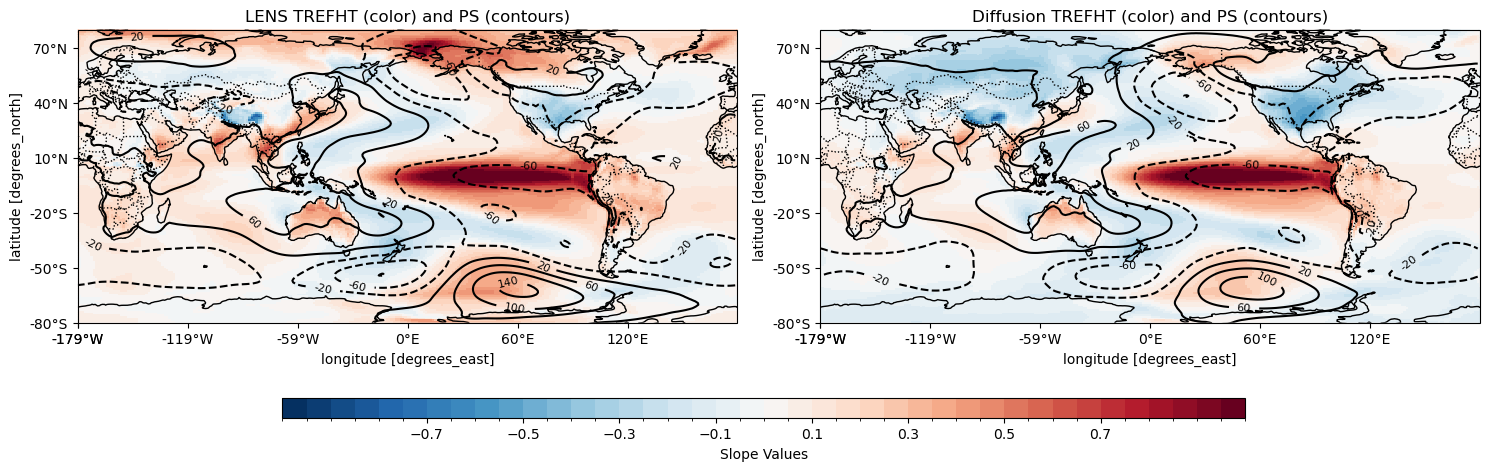

In [12]:
# Assuming slope_PS_lens, slope_PS, slope_TREFHT_lens, slope_TREFHT are calculated

# Define discrete color levels
levels = list(np.arange(-1., 1.05, .05))
cmap = plt.get_cmap('RdBu_r')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Define fewer ticks for the colorbar
fewer_ticks = [-.7, -.5, -.3, -.1, .1, .3, .5, .7]

# Standardized contour levels for both PS datasets
contour_levels = np.linspace(-300, 300, 16)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set extent for both panels (same zoomed region)
extent = [0, 360, -80, 80]  # [min_lon, max_lon, min_lat, max_lat]

# Panel 1: PRECT_lens
axs[0].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_TREFHT_lens.plot(
    ax=axs[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[0].set_title('LENS TREFHT (color) and PS (contours)')
contour_lens = axs[0].contour(slope_PS_lens['lon'], slope_PS_lens['lat'], slope_PS_lens, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[0].clabel(contour_lens, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 1
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[0].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(x)}°W'))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(y)}°S'))

# Panel 2: PRECT
axs[1].set_extent(extent, crs=ccrs.PlateCarree())
prect_plot = slope_TREFHT.plot(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False  # We'll add a single colorbar later
)
axs[1].set_title('Diffusion TREFHT (color) and PS (contours)')
contour = axs[1].contour(slope_PS['lon'], slope_PS['lat'], slope_PS, levels=contour_levels, colors='black', transform=ccrs.PlateCarree())
axs[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

# Add coastlines, borders, and tick labels for Panel 2
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
axs[1].set_yticks(np.arange(-80, 81, 30), crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(x)}°W'))
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(y)}°S'))

# Add a single shared horizontal colorbar for both panels
cbar = fig.colorbar(prect_plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2, aspect=50, ticks=fewer_ticks)
cbar.set_label('Slope Values')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()


## EOFS?

In [16]:
from eofs.xarray import Eof

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/2677888201.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


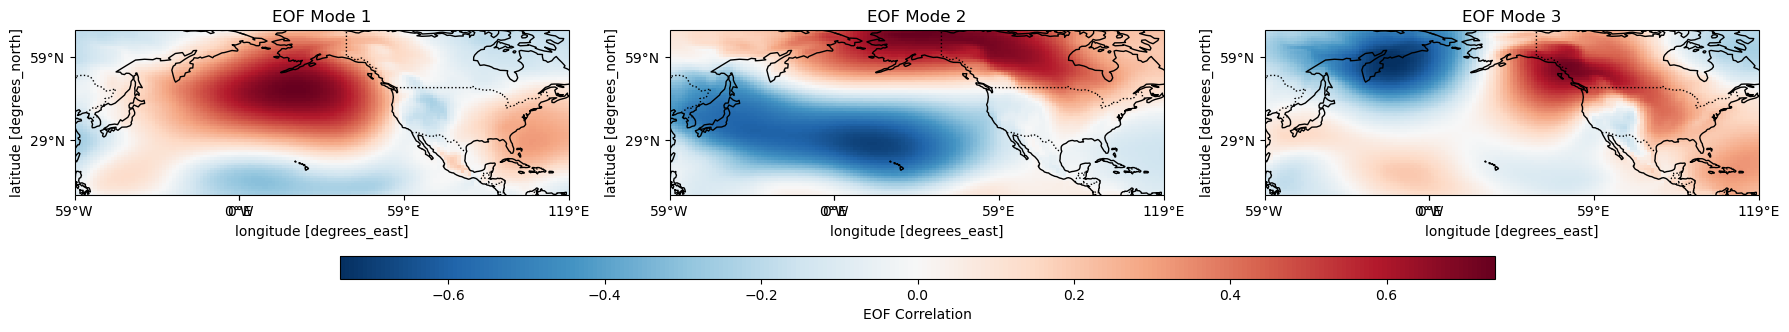

In [61]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DS_lens['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/3736123211.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


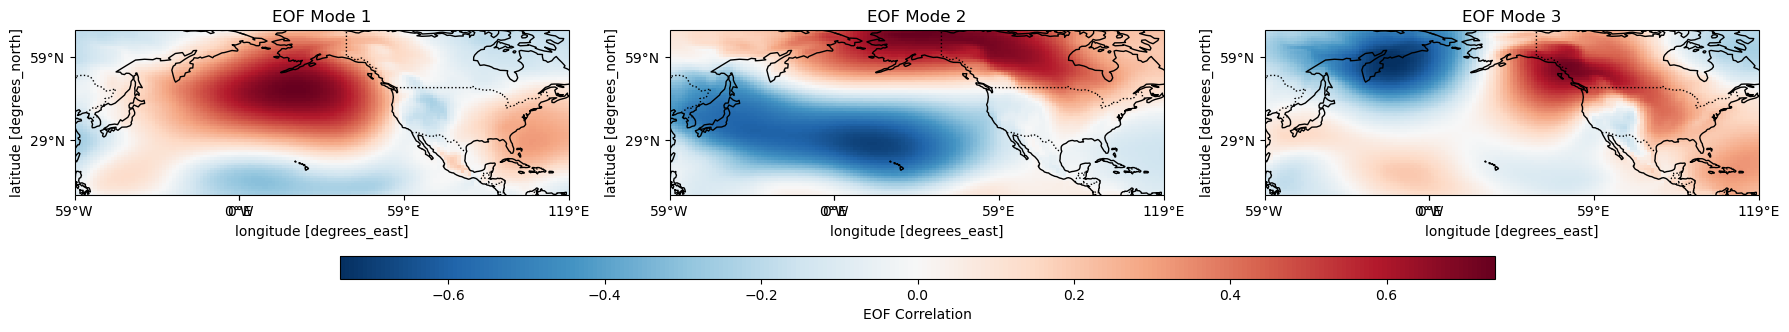

/glade/derecho/scratch/wchapman/tmp/ipykernel_187384/3736123211.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


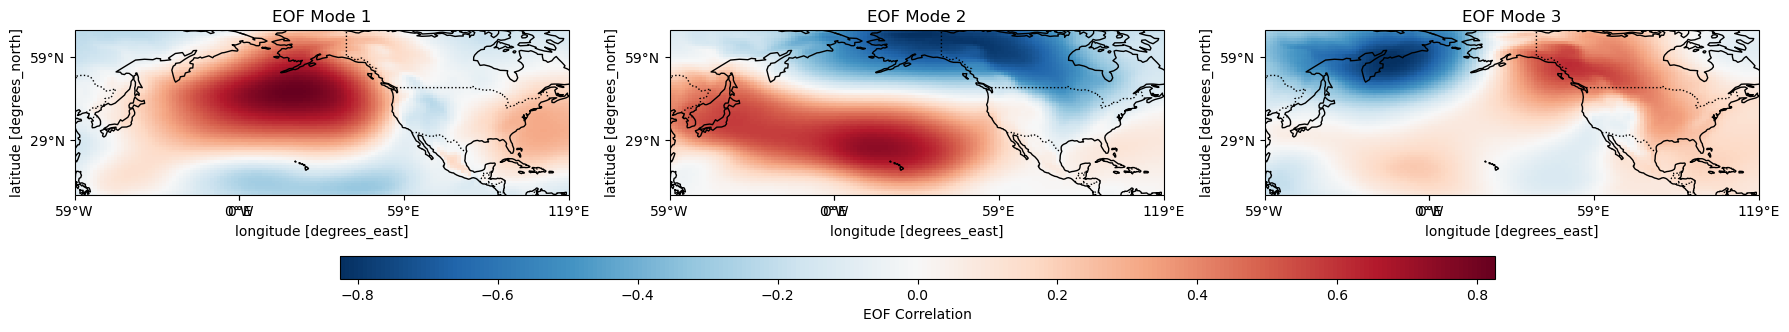

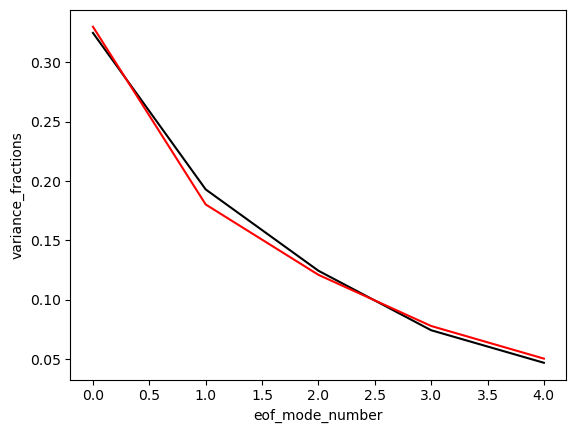

In [64]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DS['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver2 = Eof(PS, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc2 = solver2.pcs(npcs=3, pcscaling=1)

# Assuming PS is already calculated from the dataset DS_lens
PS = DS_lens['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)



# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = -1*eof2.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

solver1.varianceFraction(neigs=5).plot(color='k')
solver2.varianceFraction(neigs=5).plot(color='r')
plt.show()